In [2]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql

import math

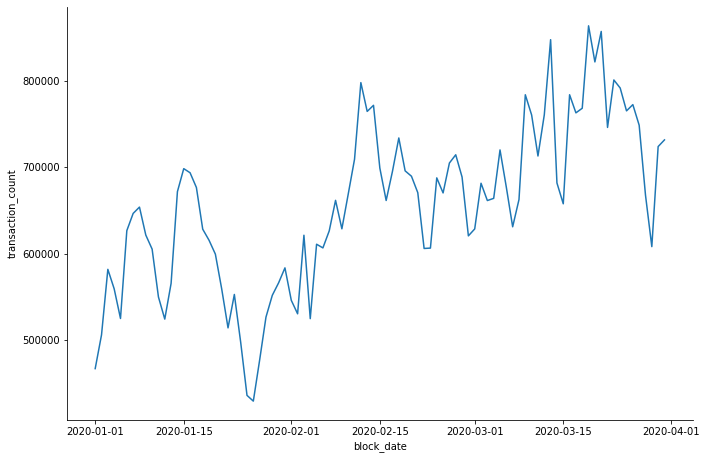

In [7]:
# import data

db = pymysql.connect(
        host='127.0.0.1', 
        port=3306, 
        user='root', 
        passwd='gkqehk12', 
        db='ethereum_data', 
        charset='utf8',
        autocommit=True,
        cursorclass=pymysql.cursors.DictCursor
    )
cursor = db.cursor() 

def get_pricedata(cursor):
    sql = """
        SELECT 
            date(date_format(STR_TO_DATE(price_date, '%m/%d/%Y'), '%Y-%m-%d')) as price_date,
            close_price as price
        FROM price_data
        where date(date_format(STR_TO_DATE(price_date, '%m/%d/%Y'), '%Y-%m-%d'))
            between date('2020-01-01') and date('2020-03-31')
    """
    cursor.execute(sql)
    result = cursor.fetchall()
    # pricedata = result.to_dataframe
    pricedata = pd.DataFrame(result)
    return pricedata

def get_blockdata(cursor):
    sql = """
        SELECT 
            timestamp,
            date(timestamp) as block_date,
            number,
            hash,
            miner,
            truncate(cast(difficulty as signed), -1) as difficulty,
            cast(total_difficulty as unsigned) as total_difficulty,
            -- log10(truncate(cast(difficulty as signed), -1)) as difficulty,
            -- log10(cast(total_difficulty as unsigned)) as total_difficulty,
            size,
            gas_limit,
            gas_used,
            transaction_count
        FROM block_data
        where date(timestamp)
            between date('2020-01-01') and date('2020-03-31')
    """
    cursor.execute(sql)
    result = cursor.fetchall()
    # blockdata = result.to_dataframe
    blockdata = pd.DataFrame(result)
    return blockdata

def get_transactiondata(cursor):
    sql = """
        SELECT 
            *
        FROM mart_transaction
        where date(block_date)
            between date('2020-01-01') and date('2021-03-31')
    """
    cursor.execute(sql)
    result = cursor.fetchall()
    # transactiondata = result.to_dataframe
    transactiondata = pd.DataFrame(result)
    return transactiondata

blockdata = get_blockdata(cursor)
transactiondata = get_transactiondata(cursor)
pricedata = get_pricedata(cursor)

# Quick Look Query
def plot_block_num(data):
    fe_data = data[['block_date', 'transaction_count']]
    fe_data = fe_data.groupby(['block_date'], as_index=False).sum()
    block_num_plot = sns.relplot(x='block_date', y='transaction_count', kind='line', height=6.27, aspect=9.7/6.27, data=fe_data)
    return block_num_plot

plot_block_num(blockdata)

In [19]:
# import active data from bq marting query

from google.cloud import bigquery
from google.cloud import bigquery_storage
import os
import pandas as pd
from pandas import DataFrame

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/Users/SeungWoo-Jung/Documents/Dev_Project/Airboard_Data_Back/key_file/airboard-339910-fc9ad1f74f70.json'
# ref - https://soundprovider.tistory.com/entry/GCP-Python%EC%97%90%EC%84%9C-GCP-Cloud-Storage-%EC%97%B0%EB%8F%99%ED%95%98%EA%B8%B0

client = bigquery.Client()

query_mart_active_miner = """
    SELECT 
        * 
    FROM `airboard-339910.datamart.mart_active_miner` 
    where 
        date(dates) between date('2020-01-01') and date('2020-03-31')
"""

query_mart_active_sender = """
    SELECT 
        * 
    FROM `airboard-339910.datamart.mart_active_sender_2020` 
    where 
        date(dates) between date('2020-01-01') and date('2020-03-31')
"""

uniqueminerdata = (
    client.query(query_mart_active_miner)
            .result()
            .to_dataframe()
)

uniquesenderdata = (
    client.query(query_mart_active_sender)
            .result()
            .to_dataframe()
)


In [20]:
# check data

def checkdata(*args):
    for i in args:
        # return i.head()
        print(i.head())

checkdata(blockdata, transactiondata, pricedata, uniqueminerdata, uniquesenderdata)
print(blockdata.dtypes)

            timestamp  block_date   number  \
0 2020-03-10 21:21:18  2020-03-10  9646114   
1 2020-03-10 17:09:35  2020-03-10  9644970   
2 2020-03-10 14:40:03  2020-03-10  9644308   
3 2020-03-10 10:38:07  2020-03-10  9643267   
4 2020-03-10 13:48:31  2020-03-10  9644090   

                                                hash  \
0  0xcaa6728e084b8f671572dc6e6d4c2f7e891ca70e0e9c...   
1  0x94a82ec63c2fa24d2fa6f7f9b08b60aa44c835cad6f2...   
2  0xd50fec027673f5888f351048147d7aff8b0d71024247...   
3  0x8f1dd356a490b1c9dc6ae1025adf56a73bd8804585bc...   
4  0xf4fdf6d87f0083d596b9c8b8eb9420990f4de9e1d0fd...   

                                        miner        difficulty  \
0  0xea674fdde714fd979de3edf0f56aa9716b898ec8  2255841699783810   
1  0xea674fdde714fd979de3edf0f56aa9716b898ec8  2232343238010890   
2  0x829bd824b016326a401d083b33d092293333a830  2265684313261640   
3  0x04668ec2f57cc15c381b461b9fedab5d451c8f7f  2339309348717560   
4  0x829bd824b016326a401d083b33d092293333a830  2285

In [21]:
# join data
def handle_block(data):
    data = data.groupby(['block_date'], as_index=False).agg({
        'miner': pd.Series.nunique,
        'difficulty': np.sum,
        'total_difficulty': np.sum,
        'size': np.sum,
        'gas_limit': np.sum,
        'gas_used': np.sum,
        'transaction_count': np.sum
    })
    data['cum_difficulty_sum'] = data.groupby(by=[
        'block_date'
    ])['difficulty'].cumsum()
    # data.columns = ['miner', 'difficulty', 'size', 'gas_limit', 'gas_used']
    data.rename(columns = {
        'miner' : 'unique_miner',
        'difficulty' : 'difficulty_sum',
        'total_difficulty' : 'total_difficulty_sum',
        'size': 'size_sum',
        'gas_limit': 'gas_limit_sum',
        'gas_used': 'gas_used_sum',
        'transaction_count': 'transaction_count'
    }, inplace = True)
    data['difficulty_sum'] = data['difficulty_sum'].div(1000000000000).round(-1)
    data['total_difficulty_sum'] = data['total_difficulty_sum'].div(1000000000000000).round(-1)
    # groupby ref - https://ponyozzang.tistory.com/291
    # unique ref - https://stackoverflow.com/questions/18554920/pandas-aggregate-count-distinct
    return data

def join_data(data1, data2, data3, data4, data5):
    first_join = pd.merge(data1, data2, left_on='price_date', right_on='block_date', how='outer')
    second_join = pd.merge(first_join, data3, left_on='block_date', right_on='block_date', how='outer')
    third_join = pd.merge(second_join, data4, left_on='block_date', right_on='dates', how='outer')
    final_join = pd.merge(third_join, data5, left_on='block_date', right_on='dates', how='outer')

    final_join['value_sum'] = final_join['value_sum'].div(1000000000000000).round(-1)
    return final_join

blockdata_agg = handle_block(blockdata)
print(blockdata_agg.head())
# print(blockdata_agg.head(-5))

joinned_data = join_data(pricedata, blockdata_agg, transactiondata, uniqueminerdata, uniquesenderdata)

   block_date  unique_miner  difficulty_sum  total_difficulty_sum   size_sum  \
0  2020-01-01            52      12229900.0            91864790.0  102320743   
1  2020-01-02            58      12619290.0           104759060.0  114363780   
2  2020-01-03            58      12933780.0           120309660.0  126487497   
3  2020-01-04            57      13647070.0           121195110.0  125017358   
4  2020-01-05            58      13242840.0           119682480.0  119433666   

   gas_limit_sum  gas_used_sum  transaction_count  cum_difficulty_sum  
0    49535070885   37252588523             466526        1.222990e+19  
1    56135857600   37401007834             505639        1.261929e+19  
2    64292417844   42156338080             581641        1.293378e+19  
3    64611354527   38519976135             559074        1.364707e+19  
4    63746506846   38136631874             524664        1.324284e+19  


price                     float64
unique_miner                int64
difficulty_sum            float64
transaction_count           int64
gas_sum                     int64
unique_sender               int64
value_sum                 float64
active_miner                int64
distinct_active_miner       int64
active_sender               int64
distinct_active_sender      int64
dtype: object
                           price  unique_miner  difficulty_sum  \
price                   1.000000     -0.396611        0.478504   
unique_miner           -0.396611      1.000000       -0.191747   
difficulty_sum          0.478504     -0.191747        1.000000   
transaction_count       0.054256      0.025425        0.530447   
gas_sum                -0.109646      0.069688        0.477186   
unique_sender           0.076662     -0.009607        0.440751   
value_sum              -0.193629      0.018577        0.290191   
active_miner           -0.642115      0.273495       -0.818755   
distinct_active_mi

<AxesSubplot:>

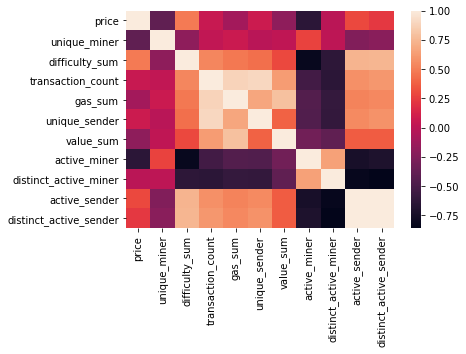

In [23]:
# Pearson correlation test

def pearson_corr(data):
    data = data[['price', 'unique_miner', 'difficulty_sum', 'transaction_count', 'gas_sum', 'unique_sender', 'value_sum', 'active_miner', 'distinct_active_miner', 'active_sender', 'distinct_active_sender']]
    data = data.astype({'gas_sum' : np.int64})
    # data.to_numeric('gas_sum')
    corr = data.corr(method='pearson')
    print(data.dtypes)
    print(corr)
    corr_heatmap = sns.heatmap(corr)
    return corr_heatmap

pearson_corr(joinned_data)


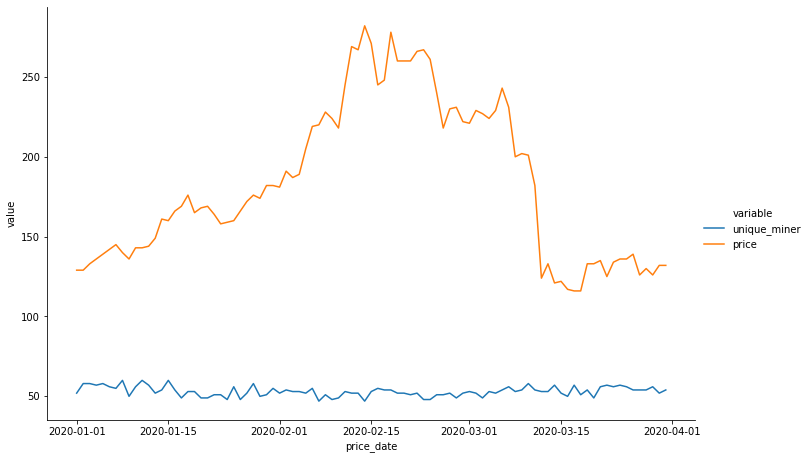

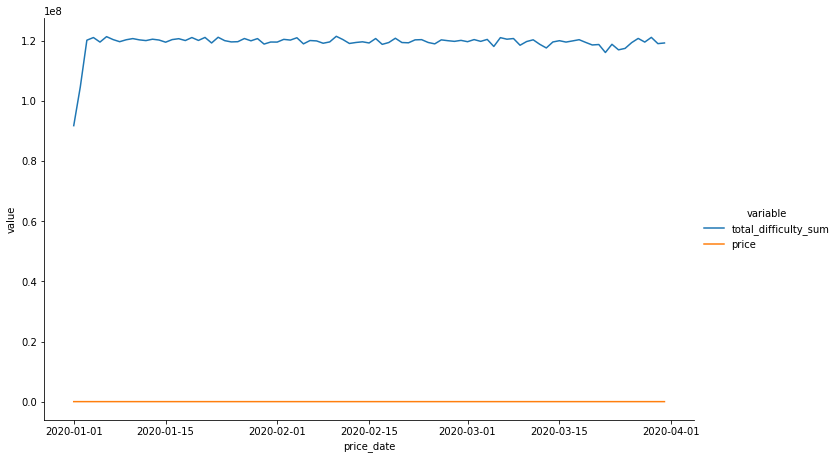

In [24]:
# plot price and active miner

def plot_active_miner(data):
    fe_data = data[['price_date', 'unique_miner', 'price']]
    fe_data = pd.melt(fe_data, ['price_date'])
    fe_data = fe_data.astype({'value':'int'})
    plot_unique_miner = sns.relplot(
        x='price_date', 
        y='value', 
        kind='line', 
        hue='variable',
        height=6.27, 
        aspect=9.7/6.27, 
        data=fe_data
    )
    # plot_unique_miner.set(yscale='log')
    return plot_unique_miner

def plot_difficulty(data):
    fe_data = data[['price_date', 'total_difficulty_sum', 'price']]
    fe_data = pd.melt(fe_data, ['price_date'])
    fe_data = fe_data.astype({'value':'int'})
    plot_difficulty = sns.relplot(
        x='price_date', 
        y='value', 
        kind='line', 
        hue='variable',
        height=6.27, 
        aspect=9.7/6.27, 
        data=fe_data
    )
    # plot_difficulty.set(yscale='log')
    return plot_difficulty
    # print(fe_data.head())

plot_active_miner(joinned_data)
plot_difficulty(joinned_data)

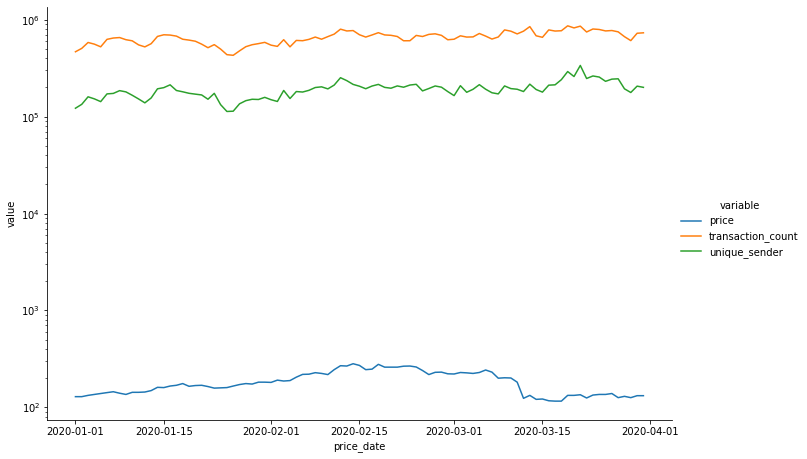

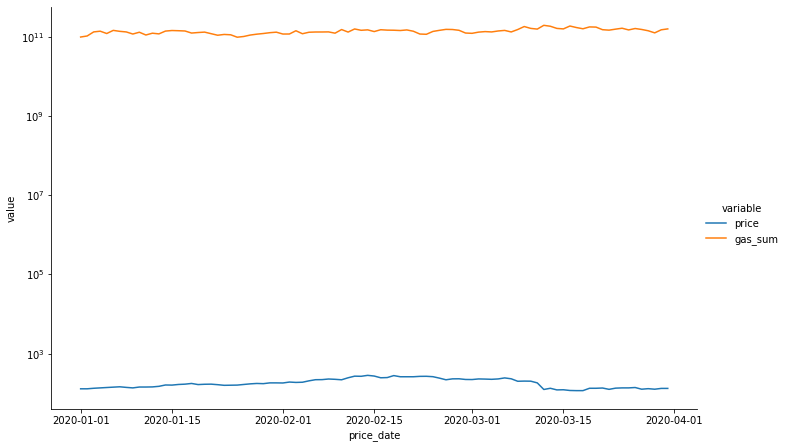

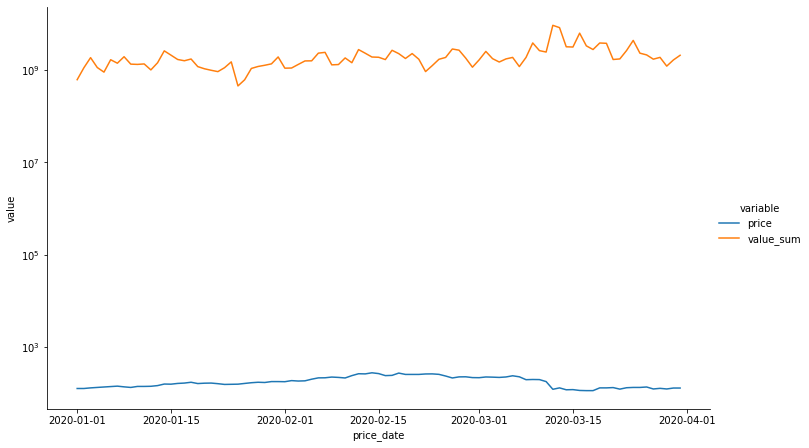

In [ ]:
# plot price and active address

def plot_trx_sender(data):
    fe_data = data[['price_date', 'price', 'transaction_count', 'unique_sender']]
    fe_data = pd.melt(fe_data, ['price_date'])
    fe_data = fe_data.astype({'value':'int'})
    plot_trx_sender = sns.relplot(
        x='price_date', 
        y='value', 
        kind='line', 
        hue='variable',
        height=6.27, 
        aspect=9.7/6.27, 
        data=fe_data
    )
    plot_trx_sender.set(yscale='log')
    return plot_trx_sender

def plot_gas_used(data):
    fe_data = data[['price_date','price', 'gas_sum']]
    fe_data = pd.melt(fe_data, ['price_date'])
    fe_data = fe_data.astype({'value':'int'})
    plot_gas_used = sns.relplot(
        x='price_date', 
        y='value', 
        kind='line', 
        hue='variable',
        height=6.27, 
        aspect=9.7/6.27, 
        data=fe_data
    )
    plot_gas_used.set(yscale='log')
    return plot_gas_used

def plot_value(data):
    fe_data = data[['price_date','price', 'value_sum']]
    fe_data = pd.melt(fe_data, ['price_date'])
    fe_data = fe_data.astype({'value':'int'})
    plot_value = sns.relplot(
        x='price_date', 
        y='value', 
        kind='line', 
        hue='variable',
        height=6.27, 
        aspect=9.7/6.27, 
        data=fe_data
    )
    plot_value.set(yscale='log')
    return plot_value

plot_trx_sender(joinned_data)
plot_gas_used(joinned_data)
plot_value(joinned_data)

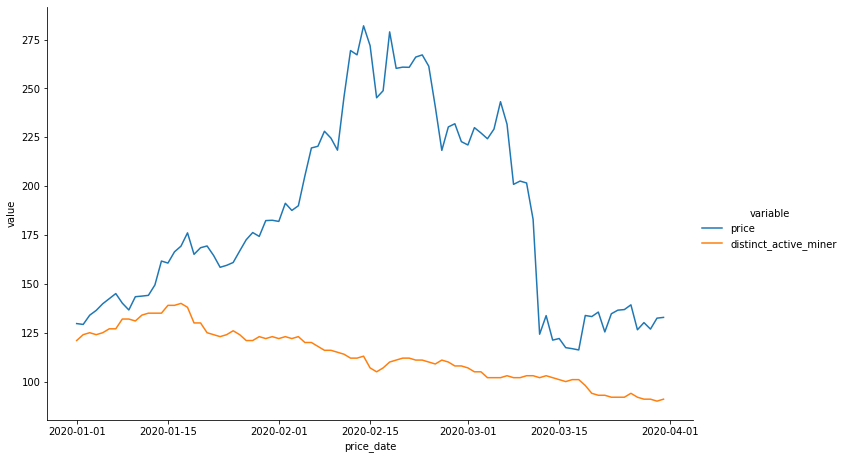

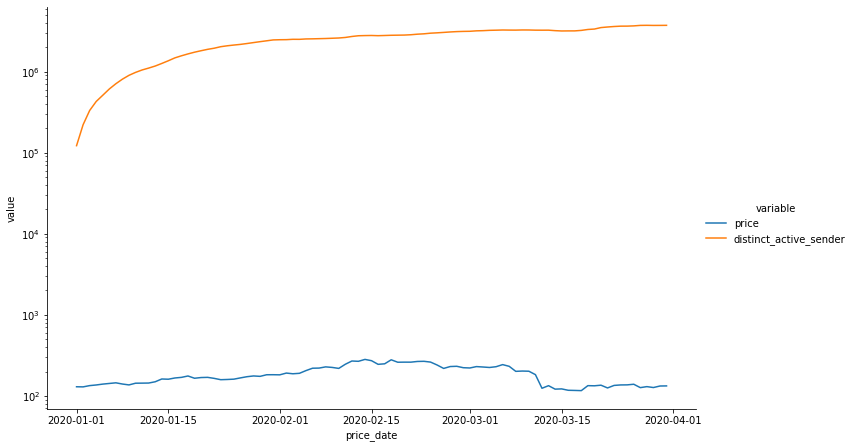

In [26]:
# plot active miner and address

def plot_active_miner(data):
    fe_data = data[['price_date', 'price', 'distinct_active_miner']]
    fe_data = pd.melt(fe_data, ['price_date'])
    # fe_data = fe_data.astype({'value':'int'})
    plot_active_miner = sns.relplot(
        x='price_date', 
        y='value', 
        kind='line', 
        hue='variable',
        height=6.27, 
        aspect=9.7/6.27, 
        data=fe_data
    )
    # plot_active_miner.set(yscale='log')
    return plot_active_miner

def plot_active_sender(data):
    fe_data = data[['price_date', 'price', 'distinct_active_sender']]
    fe_data = pd.melt(fe_data, ['price_date'])
    # fe_data = fe_data.astype({'value':'int'})
    plot_active_sender = sns.relplot(
        x='price_date', 
        y='value', 
        kind='line', 
        hue='variable',
        height=6.27, 
        aspect=9.7/6.27, 
        data=fe_data
    )
    plot_active_sender.set(yscale='log')
    # plot_active_sender.set(yscale='log')
    return plot_active_sender

plot_active_miner(joinned_data)
plot_active_sender(joinned_data)